In [11]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import linalg as splinalg
import time

In [3]:
def random_complex(M, N):
    return np.random.uniform(-1, 1, (M, N)) + 1j * np.random.uniform(-1, 1, (M, N))

**2.1**

In [4]:
def DFT_matrix(N):
    axis_vals = np.arange(start=0, stop=N, step=1)
    return np.exp(-2 * np.pi * 1j * 1/N * np.einsum("i, j -> ij", axis_vals, axis_vals))


def apply_DFT(x):
    N = np.shape(x)[1]
    return np.einsum("ij, kj -> ki", DFT_matrix(N), x)

In [12]:
def test_dft_matrix():
    N = 512
    my_mat = DFT_matrix(N)
    scipy_mat = splinalg.dft(N, None)
    np.testing.assert_allclose(my_mat, scipy_mat)


def test_dft():
    N = 512
    M = 1
    x = random_complex(M, N)
    my_dft = apply_DFT(x)
    numpy_dft = np.fft.fft(x, axis=1)
    np.testing.assert_allclose(my_dft, numpy_dft)

In [13]:
test_dft_matrix()
test_dft()

**2.3 (Code)**

In [14]:
def generate_cached_dft(n_vals):
    dft_mats = {}
    for N in n_vals:
        dft_mats[N] = DFT_matrix(N)

    def apply_cached_DFT(x):
        N = np.shape(x)[1]
        return np.einsum("ij, kj -> ki", dft_mats[N], x)

    return apply_cached_DFT

**3.1**

In [15]:
def apply_FFT(x):
    N = np.shape(x)[1]
    if N == 1:
        return x
    k_vals = np.arange(start=0, stop=N, step=1)
    even_fft = apply_FFT(x[:, 0::2])
    odd_fft = apply_FFT(x[:, 1::2])
    return np.concatenate([even_fft, even_fft], axis=-1) +\
           np.exp(-2 * np.pi * 1j * k_vals/N) * np.concatenate([odd_fft, odd_fft], axis=-1)


In [16]:
def test_fft():
    N = 512
    M = 1
    x = random_complex(M, N)
    my_fft = apply_FFT(x)
    numpy_fft = np.fft.fft(x, axis=-1)
    np.testing.assert_allclose(my_fft, numpy_fft)

In [17]:
test_fft()

**Generate Timing Plots for Everything**

In [18]:
def random_timing_plot(M, n_max, n_repeats):
    n_vals = 2 ** np.arange(start=0, stop=n_max + 1, step=1)
    apply_cached_DFT = generate_cached_dft(n_vals)
    my_dft_times = []
    my_cached_dft_times = []
    numpy_fft_times = []
    my_fft_times = []
    for N in n_vals:
        print(N)
        x_vals = [random_complex(M, N) for _ in range(n_repeats)]
        my_start_time = time.time()
        _ = [apply_DFT(x) for x in x_vals]
        my_end_time = time.time()
        my_cached_start_time = time.time()
        _ = [apply_cached_DFT(x) for x in x_vals]
        my_cached_end_time = time.time()
        my_fft_start_time = time.time()
        _ = [apply_FFT(x) for x in x_vals]
        my_fft_end_time = time.time()
        numpy_start_time = time.time()
        _ = [np.fft.fft(x) for x in x_vals]
        numpy_end_time = time.time()
        my_dft_times.append((my_end_time - my_start_time)/n_repeats)
        my_cached_dft_times.append((my_cached_end_time - my_cached_start_time)/n_repeats)
        my_fft_times.append((my_fft_end_time - my_fft_start_time)/ n_repeats)
        numpy_fft_times.append((numpy_end_time - numpy_start_time) / n_repeats)
    fig, axs = plt.subplots()
    axs.plot(n_vals, my_dft_times, label="My DFT")
    axs.plot(n_vals, my_cached_dft_times, label="My Cached DFT")
    axs.plot(n_vals, my_fft_times, label="My FFT")
    axs.plot(n_vals, numpy_fft_times, label="Numpy FFT")
    axs.legend()
    axs.set_xlabel("N")
    axs.set_ylabel("Time Per Transform (s)")
    axs.set_xscale("log")
    axs.set_yscale("log")
    return fig, axs


**Plots for M=1**

1
2
4
8
16
32
64
128
256
512
1024
2048
4096


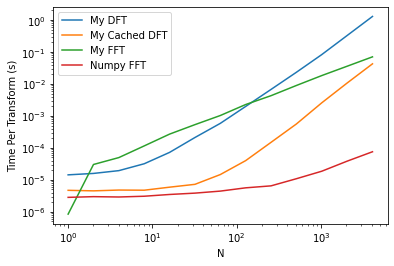

In [20]:
m1_fig, m1_axs = random_timing_plot(1, 12, 50)
m1_fig.show()

**Plots for M=100**

1
2
4
8
16
32
64
128
256
512
1024
2048
4096


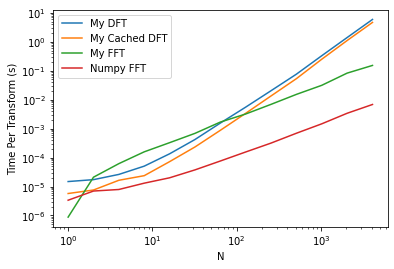

In [21]:
m100_fig, m100_axs = random_timing_plot(100, 12, 50)
m1_fig.show()

**2.2**

As can be seen in the above plot, the time taken by the implimented DFT scales as $N^2$: the slope of the curve in the log-log plot is very close to 2. 

**2.3 (Explanation)**

The caching of the DFT matricies did not change the scaling of run time at large N, as the slope of the curve is still 2. However, it did seem to signifigantly improve the constant factor, as the cached DFT is consistantly ~1.5 orders of magnitude faster than the naieve implimentation. This behavior is completely expected, as we have removed the $N^2$ matrix construction step, but the $N^2$ matrix-vector multiplication still remains. A crossover between the cached DFT and numpy FFT is not observed, but the performance of the two algorithms is similar for small N, likely limited by python overhead.

**2.4**

The plots flatten out because the overhead associated with the computation (python logic, going from python to C/fortran, etc) is taking longer than the actual base computation being performed. I would expect the value of N at which this starts occuring to get smaller as M increases, as the overhead will stay roughly the same but the numerical load will increase. Indeed, this behavior can be seen in the above plot for M=100.

**3.2**

My FFT is compared to the numpy FFT for M=1 and M=100 in the above plots. It is clear that my FFT scales the same way as the numpy FFT for large N. However, it is generally much slower than the numpy FFT and even the cached DFT in the M=1 case for the tested N values. This is probably because python recursion has a lot of overhead and numpy matrix-vector multiplication has relatively little.



**3.3**

In [29]:
def apply_FFT_cached(x, cached_fft_fn, N_min):
    N = np.shape(x)[1]
    if N == 1:
        return x
    if N == N_min:
        return cached_fft_fn(x)
    k_vals = np.arange(start=0, stop=N, step=1)
    even_fft = apply_FFT_cached(x[:, 0::2], cached_fft_fn, N_min)
    odd_fft = apply_FFT_cached(x[:, 1::2], cached_fft_fn, N_min)
    return np.concatenate([even_fft, even_fft], axis=-1) + \
           np.exp(-2 * np.pi * 1j * k_vals / N) * np.concatenate([odd_fft, odd_fft], axis=-1)

In [26]:
def test_fft_cached():
    N = 512
    M = 1
    N_min = int(N/4)
    cache_dft = generate_cached_dft([N_min])
    x = random_complex(M, N)
    my_fft = apply_FFT_cached(x, cache_dft, N_min)
    numpy_fft = np.fft.fft(x, axis=-1)
    np.testing.assert_allclose(my_fft, numpy_fft)

In [27]:
test_fft_cached()

1
2
4
8
16
32
64
128
256
512


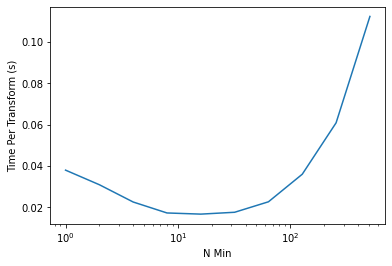

In [30]:
M = 100
n_test = 10
n_repeats = 50
N_test = 2 ** n_test
all_N_min = 2 ** np.arange(start=0, stop=n_test, step=1)
apply_cached_DFT = generate_cached_dft(all_N_min)

x_vals = [random_complex(M, N_test) for _ in range(n_repeats)]
times = []

for N_min in all_N_min:
    print(N_min)
    my_start_time = time.time()
    _ = [apply_FFT_cached(x, apply_cached_DFT, N_min) for x in x_vals]
    my_end_time = time.time()
    times.append((my_end_time - my_start_time) / n_repeats)

caching_fig, caching_axs = plt.subplots()
caching_axs.plot(all_N_min, times)
caching_axs.set_xlabel("N Min")
caching_axs.set_ylabel("Time Per Transform (s)")
caching_axs.set_xscale("log")
caching_fig.show()


As can be seen in the above plot, the optimal $N_{\text{min}}$ is somewhere between 10 and 100. This makes sense given the M=100 plot from before. My FFT is still about an order of magnitude slower than the numpy implimentation, which I think is inevitable given how slow recursion is in python.